<a href="https://colab.research.google.com/github/ShohanNur/Machine_Leanring/blob/main/notebooks/train-yolov12-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [12]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [13]:
!nvidia-smi

Thu Aug 28 18:49:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    6612MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [15]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [16]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-08-28 18:50:09--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.1’

dog.jpeg.1          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-08-28 18:50:09 (93.9 MB/s) - ‘dog.jpeg.1’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

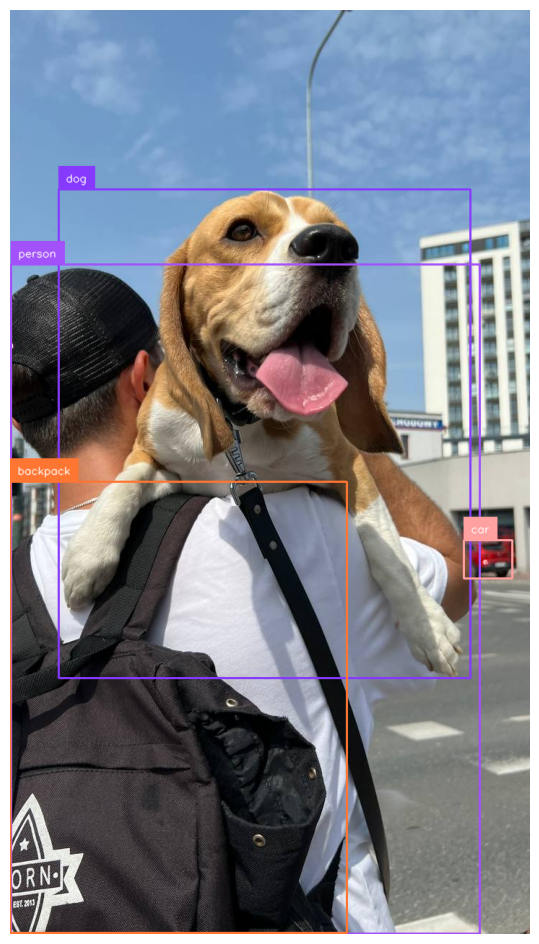

In [17]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [18]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pZ87n68pYMoWbLoYXmt3")
project = rf.workspace("hello-prhln").project("weeds_detection_test")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...


In [19]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [20]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [21]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 12
names: ['Alternanthera philoxeroide', 'Centella asiatica', 'Colocasia esculenta', 'Commelina benghalensis', 'Cyperus ochraceus', 'Fimbristylis littoralis', 'Ipomoea aquatica', 'Marsilea minuta', 'Panicum repens', 'Paspalum scrobiculatum', 'Pteris vittata', 'Synedrella nodiflora']

roboflow:
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [23]:
# from ultralytics import YOLO

# model = YOLO('yolov12s.pt')

# results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

from ultralytics import YOLO

model = YOLO('yolov12s.pt')

results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=25,
    imgsz=768,
    batch=16,
    device=0,
    patience=20,
    save_period=10,
    close_mosaic=15
)


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/Weeds_Detection_Test-1/data.yaml, epochs=25, time=None, patience=20, batch=16, imgsz=768, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=15, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning /content/Weeds_Detection_Test-1/train/labels.cache... 6432 images, 12 backgrounds, 0 corrupt: 100%|██████████| 6432/6432 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Weeds_Detection_Test-1/valid/labels.cache... 613 images, 1 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.5G      1.009      2.075       1.69         53        768: 100%|██████████| 402/402 [05:58<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]

                   all        613        707      0.711      0.666       0.73      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.3G      1.004      1.479      1.666         54        768: 100%|██████████| 402/402 [05:44<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.795      0.706      0.776      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.3G     0.9705       1.43      1.636         53        768: 100%|██████████| 402/402 [05:40<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

                   all        613        707      0.744      0.655      0.748      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.3G     0.9329      1.364      1.608         43        768: 100%|██████████| 402/402 [05:39<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

                   all        613        707      0.812      0.755       0.83      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.3G     0.9137       1.23      1.574         48        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.852      0.796      0.883       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.3G     0.8919      1.137      1.554         51        768: 100%|██████████| 402/402 [05:39<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]

                   all        613        707      0.896       0.85       0.92      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.3G     0.8627      1.072      1.535         41        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707       0.83      0.874      0.898      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.3G     0.8456      1.028      1.513         54        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]

                   all        613        707        0.9      0.854      0.931      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.3G     0.8117     0.9546      1.489         48        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.869      0.837      0.908      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.3G     0.8031     0.9017      1.473         52        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


                   all        613        707      0.933      0.906      0.935      0.662
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.3G     0.8468     0.6991      1.689         16        768: 100%|██████████| 402/402 [05:38<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.912      0.897      0.932      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.3G     0.8143     0.6215      1.646         17        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.923      0.907       0.94      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.3G     0.7938     0.5934      1.632         20        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.942      0.892      0.948      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.3G     0.7808     0.5668       1.61         16        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

                   all        613        707      0.913       0.93      0.947      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.3G     0.7502     0.5355      1.574         19        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.933      0.922      0.952      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.3G     0.7445     0.5098      1.563         20        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]

                   all        613        707      0.936      0.918       0.95      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.3G     0.7326     0.4876      1.551         16        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

                   all        613        707      0.929      0.928      0.948      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.3G     0.7103     0.4611      1.531         20        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]

                   all        613        707      0.941      0.934      0.958      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.3G     0.6816     0.4351      1.499         19        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]

                   all        613        707       0.95      0.933      0.956      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.3G      0.675     0.4211      1.492         16        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]

                   all        613        707      0.954      0.935      0.956      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.3G     0.6532     0.4003       1.46         18        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]

                   all        613        707      0.955      0.937      0.961       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.3G     0.6375     0.3845      1.447         18        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

                   all        613        707      0.958      0.944      0.965      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.3G      0.619     0.3655      1.427         18        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]

                   all        613        707      0.951      0.941      0.963      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.3G     0.5951     0.3552        1.4         20        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]

                   all        613        707      0.955      0.943      0.962      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.3G     0.5847     0.3393      1.388         18        768: 100%|██████████| 402/402 [05:37<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]

                   all        613        707      0.954      0.945      0.967      0.741



25 epochs completed in 2.444 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 18.7MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,852 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


                   all        613        707      0.954      0.945      0.967      0.741
Alternanthera philoxeroide         20         20          1      0.989      0.995      0.807
     Centella asiatica         77         98      0.804      0.795      0.856      0.618
   Colocasia esculenta         19         19          1      0.967      0.995        0.9
Commelina benghalensis         59         59          1      0.994      0.995      0.851
     Cyperus ochraceus         37         37      0.993          1      0.995      0.698
Fimbristylis littoralis         33         34      0.929      0.941      0.972       0.64
      Ipomoea aquatica         46         46      0.973          1       0.99      0.687
       Marsilea minuta         72        141      0.819      0.802      0.865      0.584
        Panicum repens         58         59      0.966      0.967      0.981      0.563
Paspalum scrobiculatum         79         80      0.974      0.934       0.98      0.832
        Pteris v

## Evaluate fine-tuned YOLOv12 model

In [24]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
events.out.tfevents.1756406784.4fa8e5de3e34.1837.0  train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    weights


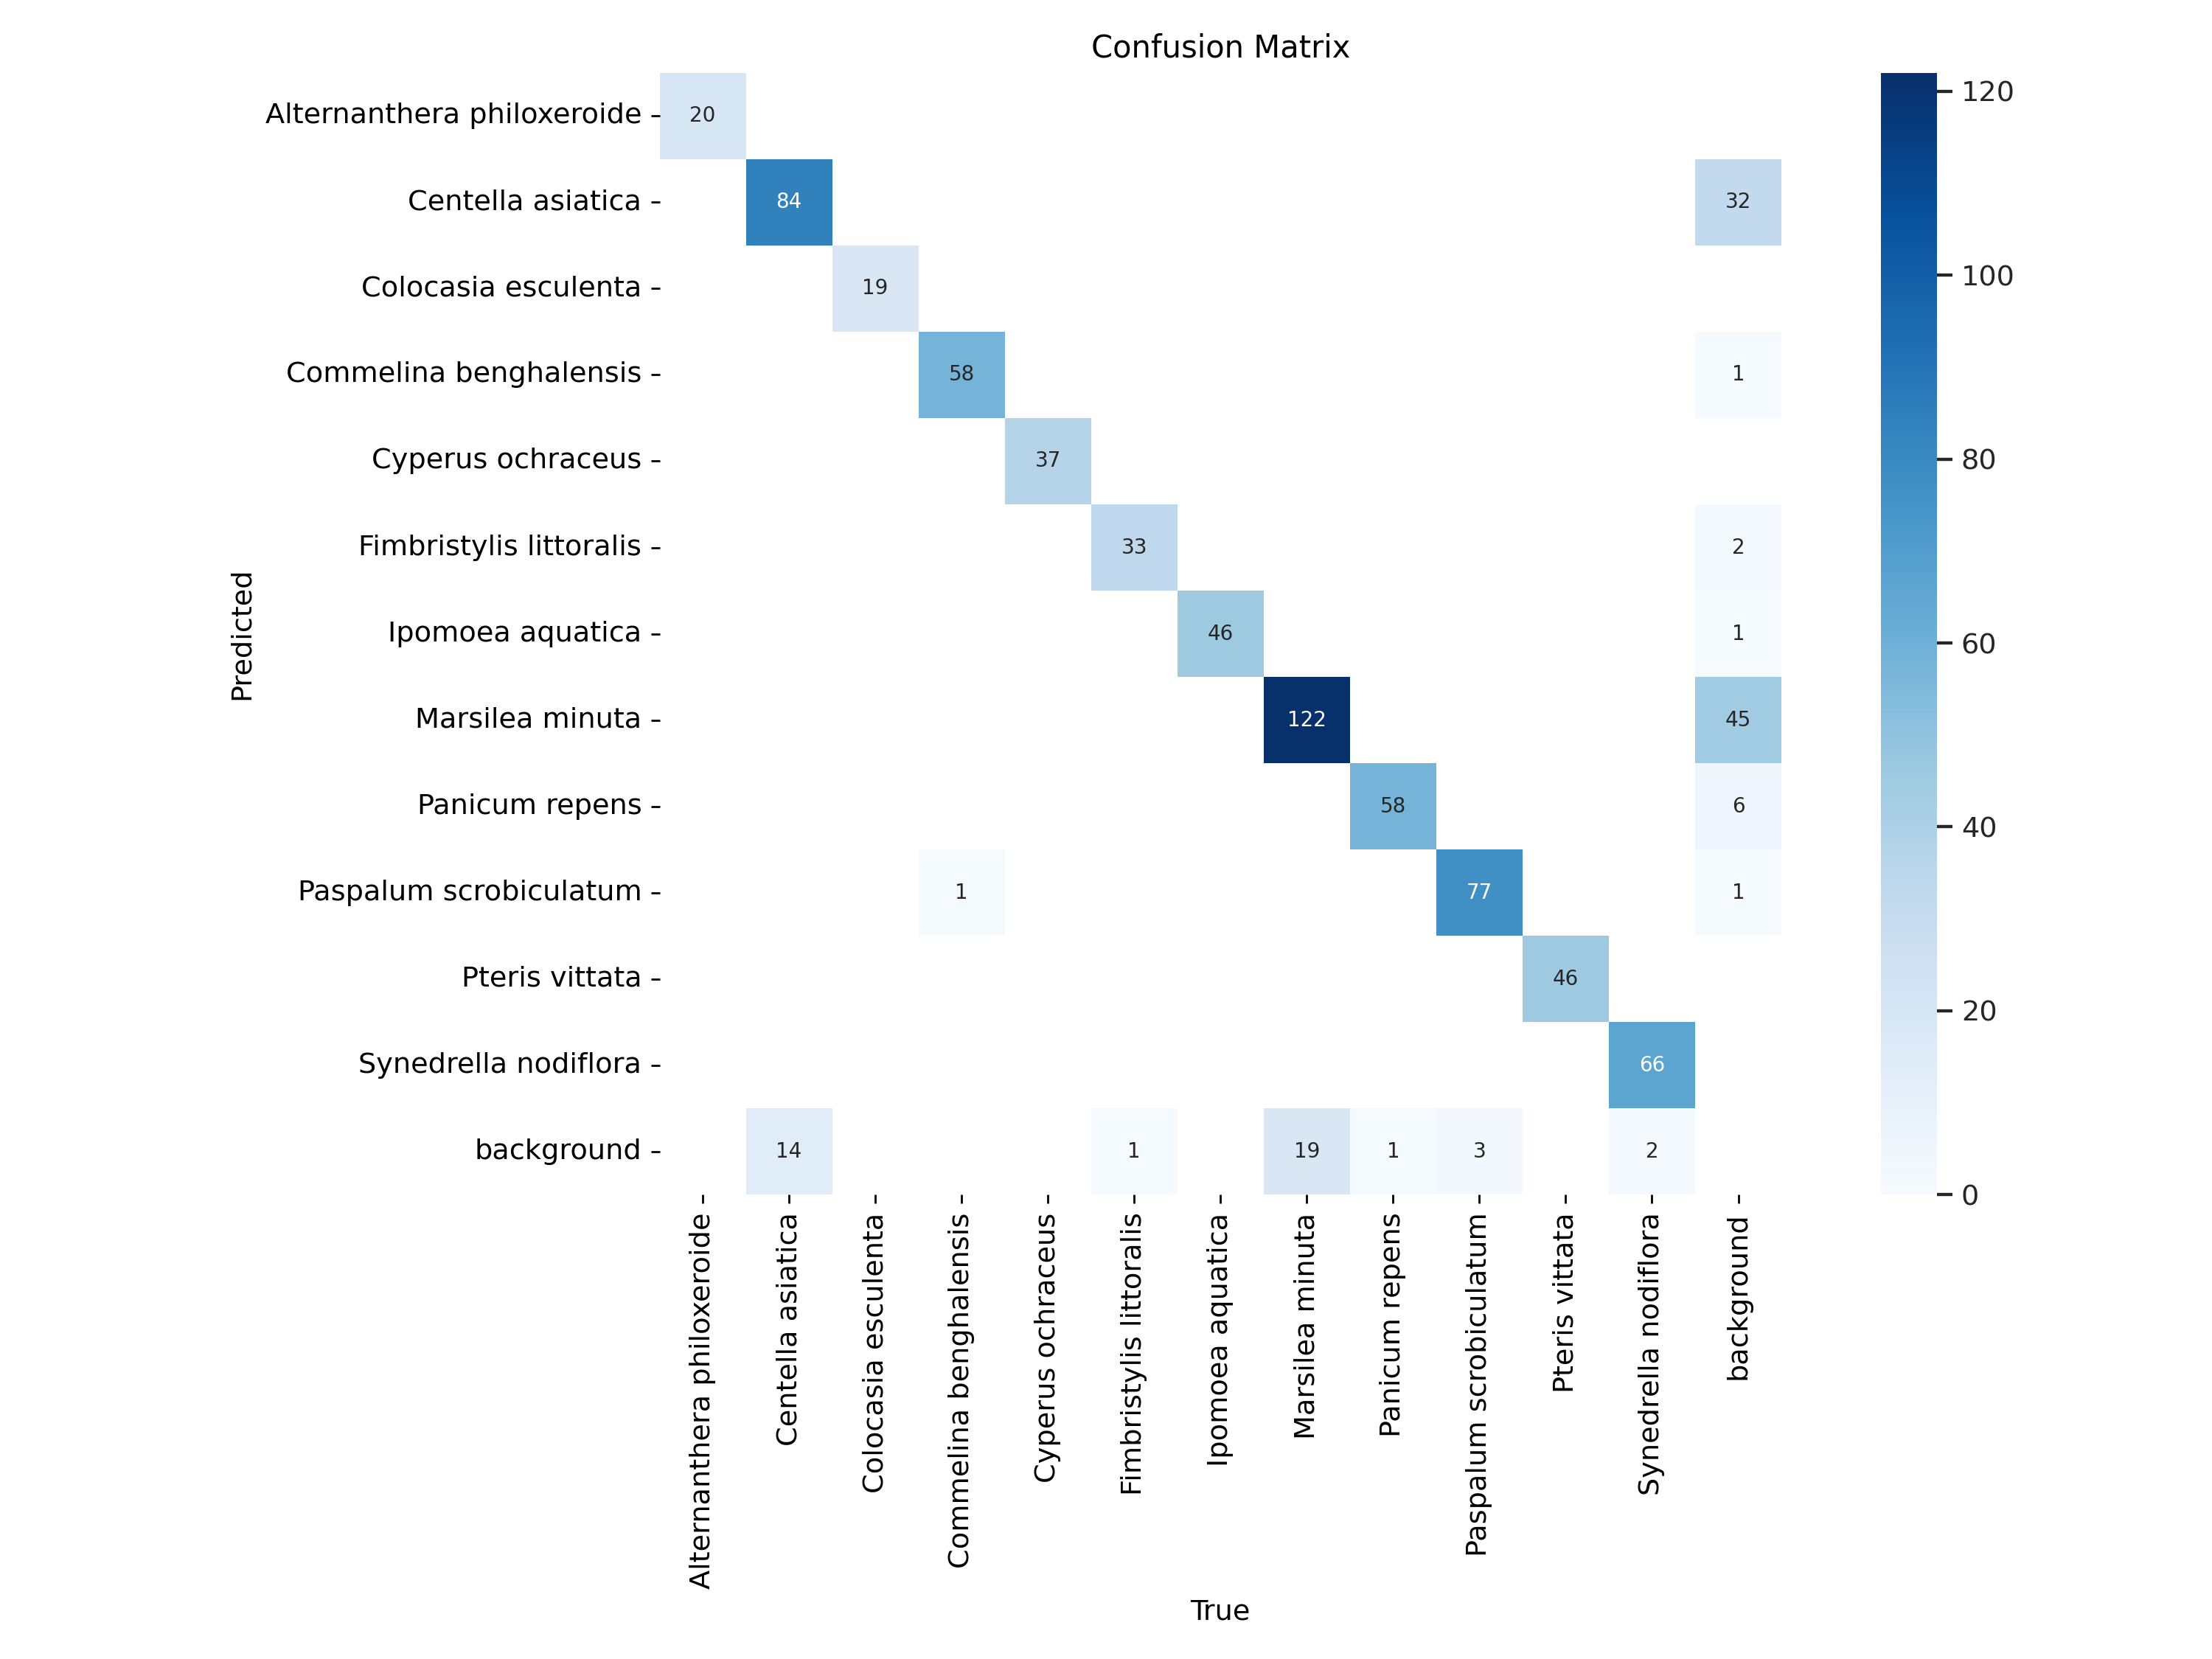

In [26]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=1000)

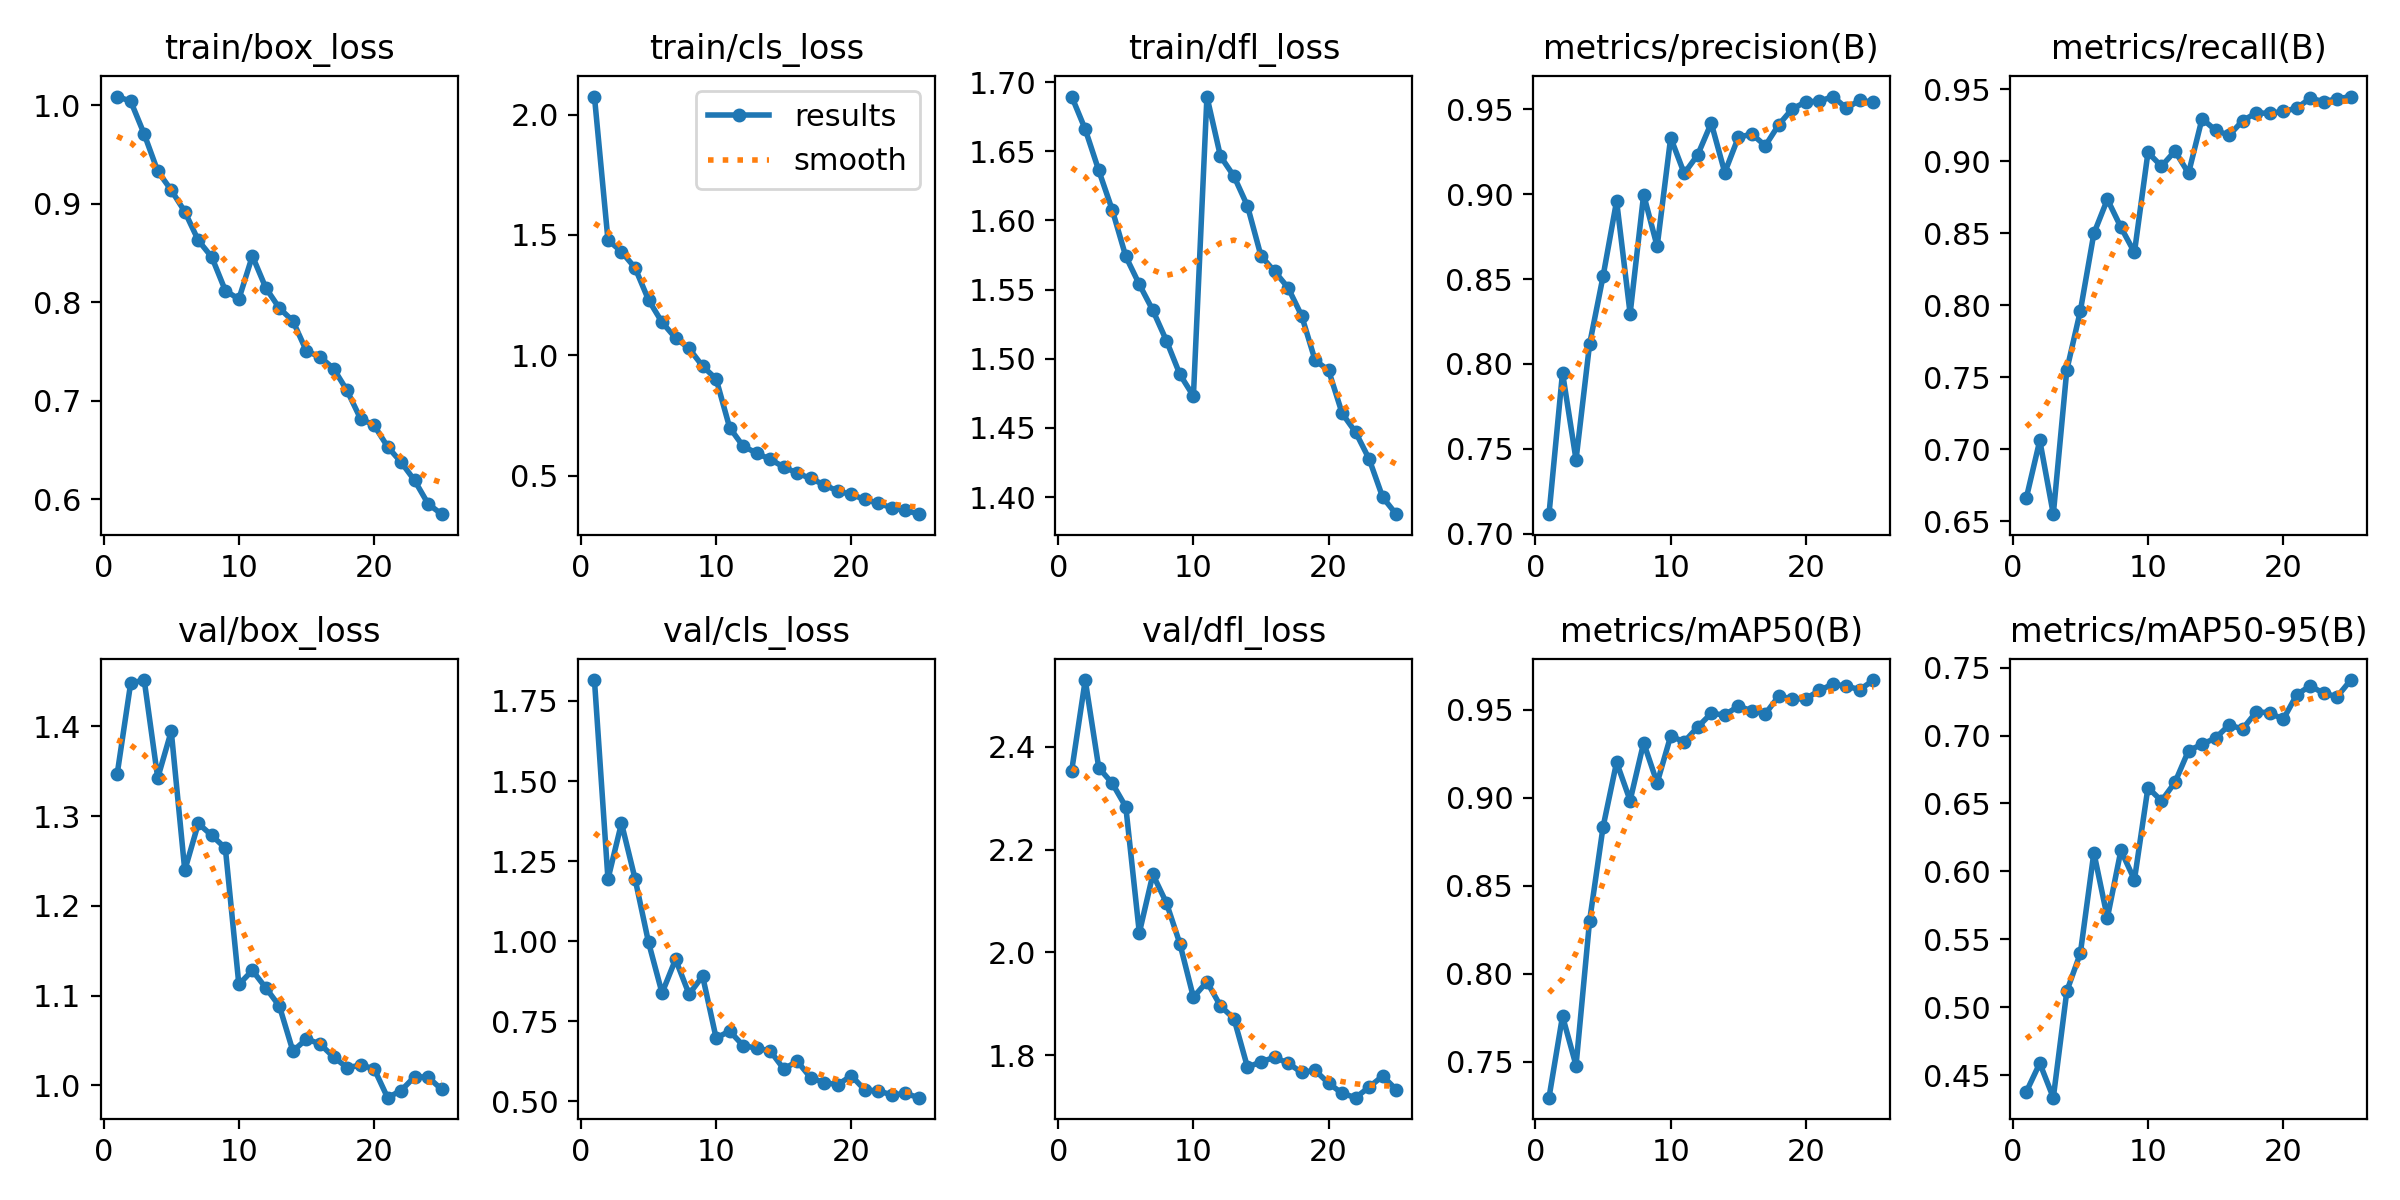

In [27]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/results.png', width=1000)

In [28]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Alternanthera philoxeroide',
 'Centella asiatica',
 'Colocasia esculenta',
 'Commelina benghalensis',
 'Cyperus ochraceus',
 'Fimbristylis littoralis',
 'Ipomoea aquatica',
 'Marsilea minuta',
 'Panicum repens',
 'Paspalum scrobiculatum',
 'Pteris vittata',
 'Synedrella nodiflora']

In [29]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [30]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6546849848625743
mAP 50 0.9285336681432149
mAP 75 0.6948328967716051


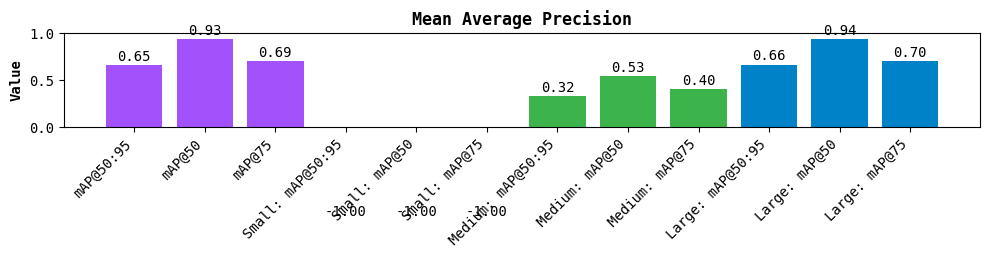

In [31]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [32]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

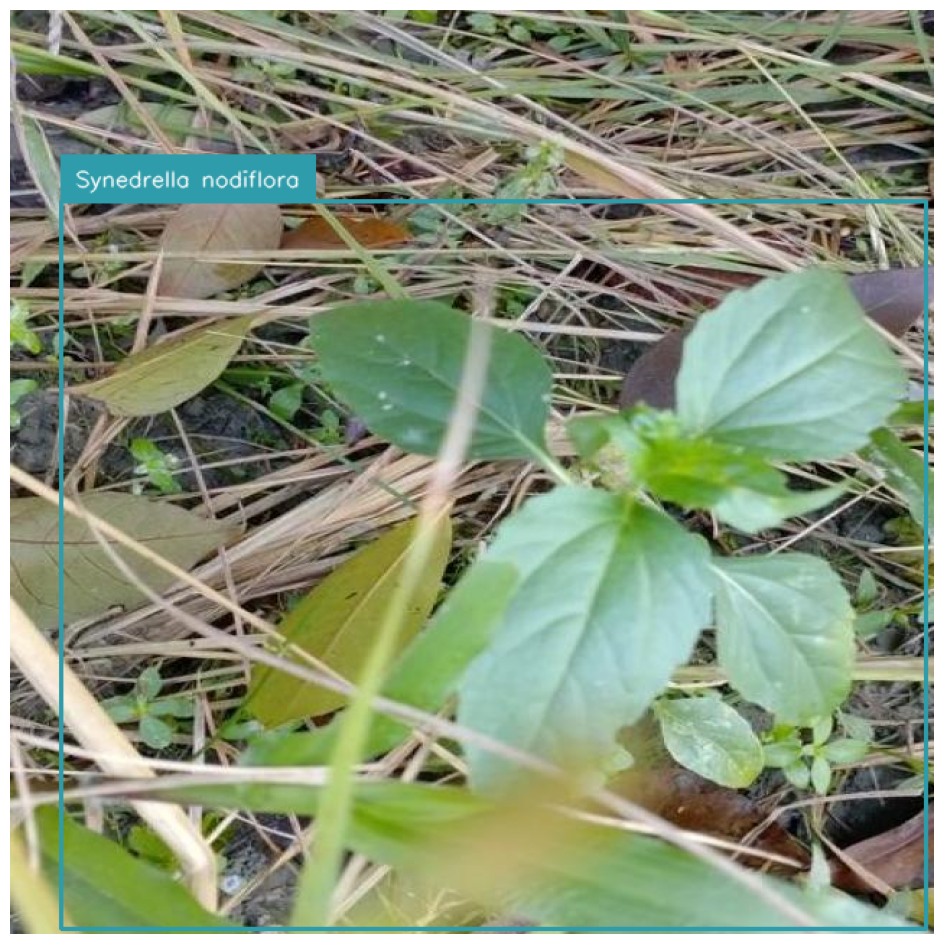

In [33]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')